In [4]:

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as col
from matplotlib.colorbar import ColorbarBase
import aplpy as apl

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord

from astropy.wcs import WCS
import astropy.units as u
from spectral_cube import SpectralCube
from pvextractor.gui import PVSlicer

In [59]:
species = 'N2D+'
filepath = "C:\\Users\\alexf\Japan internship\\N2D\\ngc1333TP.N2D.peakT.valueK.fits"

In [35]:
header = fits.getheader(filepath)
wcs = WCS(header)
#sio_wcs.wcs.ctype[2] = "VRAD"
#sio_wcs.deepcopy()
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 52.32135166667  31.45439166667  
CRPIX : 281.0  431.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0008333333333333  0.0008333333333333  
NAXIS : 560  860


In [21]:
data = fits.getdata(filepath)
# sio_header = fits.getheader("C:\\Users\\alexf\Downloads\sioconcat.fits")

'''
cube = SpectralCube(data=sio_data, wcs=sio_wcs)
cube.unit
cube_slab = cube.spectral_slab(-15.*u.km/u.s,15.*u.km/u.s)
print(cube_slab)
'''

'\ncube = SpectralCube(data=sio_data, wcs=sio_wcs)\ncube.unit\ncube_slab = cube.spectral_slab(-15.*u.km/u.s,15.*u.km/u.s)\nprint(cube_slab)\n'

In [8]:
# Load Gutermuth TSOs
tab_yso = fits.open("gutermuth_YSO")
df_yso = Table(tab_yso[1].data).to_pandas()
yso_ra, yso_dec = df_yso['RAJ2000'], df_yso['DEJ2000']
yso_positions = SkyCoord(yso_ra*u.deg,yso_dec*u.deg)
yso_pixels = wcs.world_to_pixel(yso_positions)

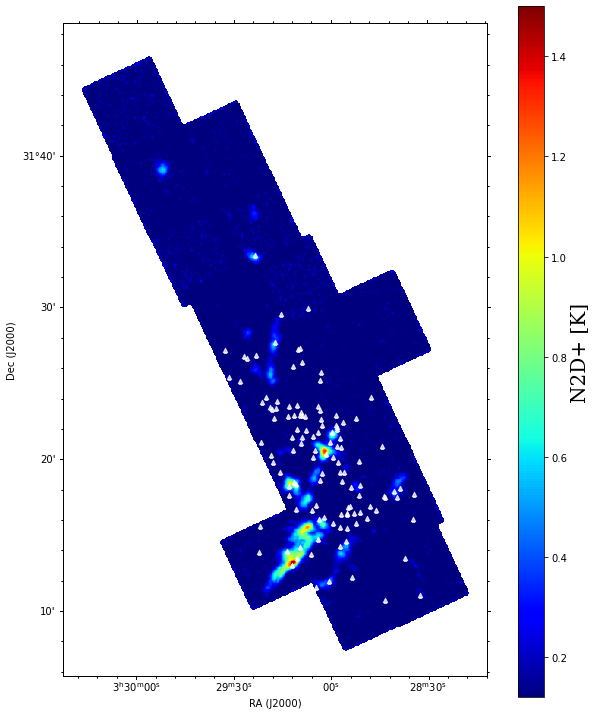

In [64]:
# Open filepath to FITS. Storing header, data and WCS as seperate things
hdu = fits.open(filepath)[0]
h = hdu.header
d = hdu.data
w = WCS(h)

# Colorbar settings
cmap = 'jet'
vmin = 0.12
vmax = 1.5
n,m,i=1,1,0
stretch = 'linear'
cb_label = f"{species} [K]" # colorbar label
figure = plt.figure(figsize=(18,12))

# Plot using aplpy: specifiying cbar paramters and plotting YSOs
fig = apl.FITSFigure(hdu, slices=[0], figure=figure, subplot=(1,1,1), convention='wells')
fig.show_colorscale(vmin=vmin, vmax=vmax, cmap=cmap, stretch='linear')
fig.ticks.set_color("k")
ax = figure.add_subplot(1,1,1)
cb = ColorbarBase(ax=ax, cmap=cmap, norm=col.Normalize(vmin=vmin, vmax=vmax), orientation="vertical")
cb.ax.set_position([0.7, 0.1, 0.02, 0.8])
cb.set_label(cb_label, size=20, family="serif")
fig.show_markers(yso_ra,yso_dec,marker='^', s=20,c='White',alpha=0.8)
fig.save(f'{species}_peakT.pdf', dpi=150)

# Experiment with FilFinder

In [7]:
import radio_beam as rd_beam
beam = rd_beam.Beam.from_fits_header(header)
print(beam)

Beam: BMAJ=29.7659139999984 arcsec BMIN=29.7659139999984 arcsec BPA=64.756331 deg


In [8]:
# Import and create FilFinder2D object
from fil_finder import FilFinder2D
hdu = fits.open(filepath)[0]
print(hdu.data)
fil = FilFinder2D(hdu,distance=299 *u.pc,beamwidth=30.0330699999984 * u.arcsecond)

print(fil.image.value)

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


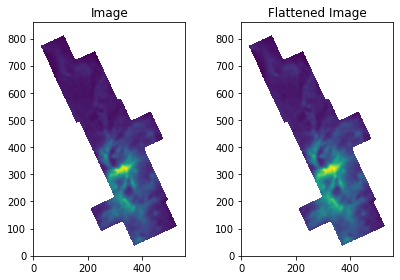

In [9]:
# Image preprocessing
flatten = 100
fil.preprocess_image(flatten_percent=flatten)


plt.subplot(121)
plt.imshow(fil.image.value, origin='lower')
plt.title("Image")
plt.subplot(122)
plt.imshow(fil.flat_img.value, origin='lower')
plt.title("Flattened Image")
plt.tight_layout()

# Had a Typerror after using flatten percent when creating a mask
# Not the best workaround but below changes the flat_img to be dimensionless
fil.flat_img = fil.flat_img.value * u.dimensionless_unscaled

c:\Users\alexf\Anaconda3\lib\site-packages\fil_finder\filfinder2D.py:355: UserWarning: Adaptive thresholding patch is larger than 40pixels. Regridding has been disabled.
  warnings.warn("Adaptive thresholding patch is larger than 40"


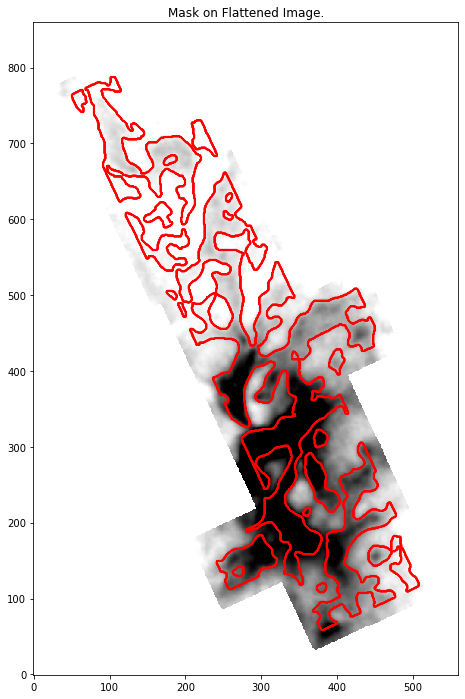

In [10]:
# Create a filament mask
plt.figure(figsize=(18, 12))
fil.create_mask(verbose=True,glob_thresh=0.1 * u.K *u.km/u.s,border_masking=True,size_thresh=5 * u.pix**2)

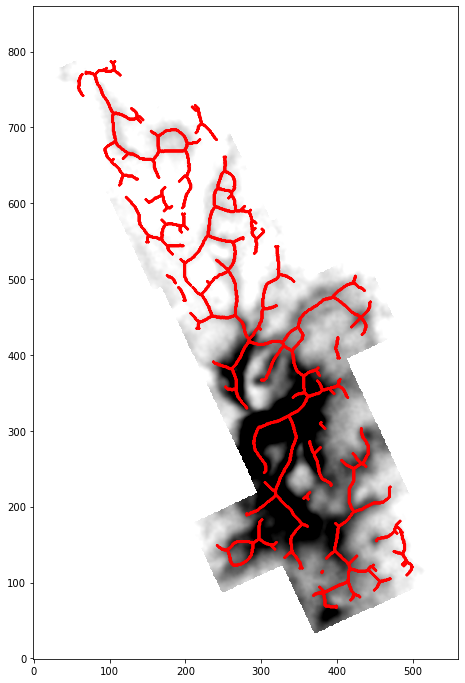

In [11]:
# convert mask into skeleton
plt.figure(figsize=(18, 12))
fil.medskel(verbose=True)

c:\Users\alexf\Anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


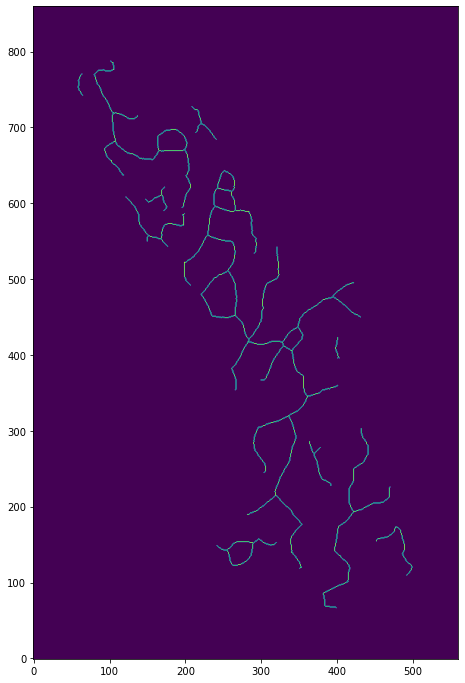

In [12]:
thresh = 0.1
fil.analyze_skeletons(skel_thresh=thresh*u.pc)
plt.figure(figsize=(18, 12))
plt.imshow(fil.skeleton,origin='lower')

In [13]:
fil.lengths(u.pc)

<Quantity [1.373499  , 0.5046924 , 3.72190164, 0.41020247, 0.31540349,
           0.13182761, 0.63006085, 0.22768178, 1.48358272, 0.2573771 ,
           0.145183  ] pc>

(20.0, 820.0)

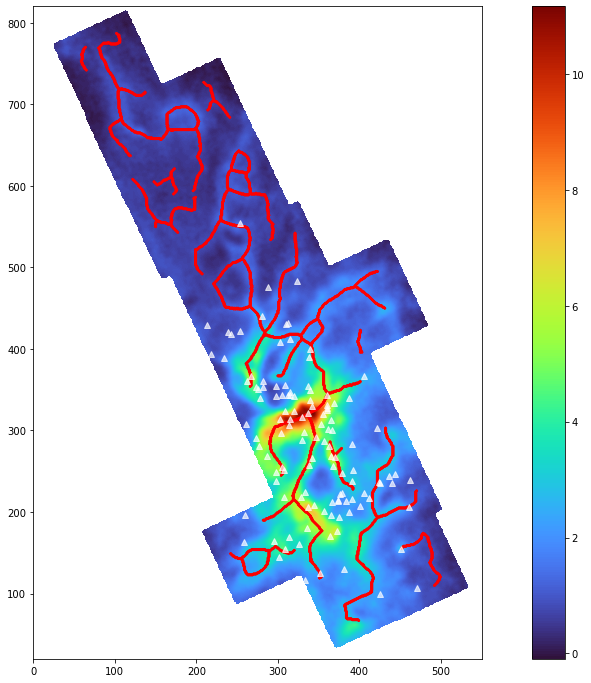

In [14]:
tab_yso = fits.open("gutermuth_YSO")
df_yso = Table(tab_yso[1].data).to_pandas()
yso_ra, yso_dec = df_yso['RAJ2000'], df_yso['DEJ2000']
yso_positions = SkyCoord(yso_ra*u.deg,yso_dec*u.deg)
yso_pixels = wcs.world_to_pixel(yso_positions)

plt.figure(figsize=(18, 12))
im = plt.imshow(data,cmap="turbo",origin="lower")
plt.colorbar(im)
plt.contour(fil.skeleton, colors='red',alpha=0.7)
#plt.contour(fil.skeleton_longpath,colors='red',alpha = 0.7)
plt.plot(yso_pixels[0],yso_pixels[1],"w^",alpha=0.7)
plt.xlim([0,550])
plt.ylim([20,820])

In [1]:
# Colorbar settings
cmap = 'jet'
vmin = 0
vmax = 10
n,m,i=1,1,0
stretch = 'linear'
cb_label = f"{species} [K km s$^{-1}$]" # colorbar label
figure = plt.figure(figsize=(18,12))

# Plot using aplpy: specifiying cbar paramters and plotting YSOs
fig = apl.FITSFigure(hdu, slices=[0], figure=figure, subplot=(1,1,1), convention='wells')
fig.show_colorscale(vmin=vmin, vmax=vmax, cmap=cmap, stretch='linear')
fig.ticks.set_color("k")
ax = figure.add_subplot(1,1,1)
cb = ColorbarBase(ax=ax, cmap=cmap, norm=col.Normalize(vmin=vmin, vmax=vmax), orientation="vertical")
cb.ax.set_position([0.7, 0.1, 0.02, 0.8])
cb.set_label(cb_label, size=20, family="serif")
fig.show_markers(yso_ra,yso_dec,marker='^', s=20,c='White',alpha=0.8)

fig.show_contour(fil.skeleton,colors='red',alpha=0.7)
apl_beam = fig.add_beam()

NameError: name 'species' is not defined

In [18]:
print(beam)
print(h)

Beam: BMAJ=29.7659139999984 arcsec BMIN=29.7659139999984 arcsec BPA=64.756331 deg
SIMPLE  =                    T /Standard FITS                                   BITPIX  =                  -32 /Floating point (32 bit)                         NAXIS   =                    2                                                  NAXIS1  =                  560                                                  NAXIS2  =                  860                                                  EXTEND  =                    T                                                  BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 BZERO   =   0.000000000000E+00                                                  BMAJ    =   8.268309444444E-03                                                  BMIN    =   8.268309444444E-03                                                  BPA     =   6.475633100000E+01                                                  BTYPE   = 'Intensity'                 

In [16]:
fig.save(f'pdf/{species}_filament-flatten_{flatten}-thresh_{thresh}pc.pdf',dpi=150)